In [12]:
from nd2shrink.transform import to_8bits

In [13]:
from nd2_combine import tools
from segment import segment
from droplet_growth import multiwell
import numpy as np
import logging
import os
import math
from skimage.transform import rotate
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
path = r"Z:\Sebastien\mESC_aggregates\SUMO\23_01_2020\D_5\Chip_1.nd2"

In [2]:
path = '/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/23_01_2020/D_5/Chip_1.nd2'

In [14]:
fluo_path = '/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/SUMOICC/8001.nd2'

In [3]:
dirr = path.replace('.nd2','')
try:
    os.mkdir(dirr)
except FileExistsError:
    pass

In [15]:
def to_rgb(stack, order):
    stack8 = to_8bits(stack)
#     print(stack8.shape, stack8.dtype)
    ch = {'r': 'TRITC', 'g': 'FITC', 'b': 'DAPI'}
    rgb = np.stack([stack8[order.index(v)] for v in ch.values()], axis=-1)
#     print(rgb.shape)
#     multiwell.show(rgb)
    

In [16]:
class MultiColorWell:
    def __init__(self, stack_cyx:np.ndarray, 
                 order:list, colors={'r': 'TRITC', 'g': 'FITC', 'b': 'DAPI'}):
        stack = stack_cyx
        assert stack.ndim == 3
        self.original_stack = stack
        assert [color in order for color in colors.values()]
        stack_order = [order.index(v) for v in colors.values()]
        self.colors = colors
        self.rgb = np.stack(to_8bits(stack)[stack_order], axis=-1)
        
    def __repr__(self):
        multiwell.show(self.rgb)
        multiwell.plt.title(self.colors)
        multiwell.plt.show()
        return f'rgb {self.rgb.shape}'
                        
        
        

In [17]:
# from pims_nd2 import ND2_Reader as nd
from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='yx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
        channels = frames.metadata['channels']
        print(channels)
        px_size_um = frames.metadata['pixel_microns']
        frames.iter_axes = 'v'
        frames.default_coords['z'] = 0
        frames.bundle_axes = bundle_axes
#         if well_index is not None:
#             yield frames[well_index]
#         else:
        for f in frames:
            yield f#MultiColorWell(f, channels)

In [18]:
from pims_nd2 import ND2_Reader as nd
# from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='yx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
        channels = [
            frames.metadata[f'plane_{i}']['name'] for i in range(
                frames.sizes['c']
            )
        ]
        print(channels)
        px_size_um = frames.calibration
        frames.iter_axes = 'm'
        frames.bundle_axes = bundle_axes
        for f in frames:
            yield MultiColorWell(f, channels)

In [41]:
def filter_regions(r, maj_len=(500, 250), ecc=(0.4, 0.4)):
    return   (r.major_axis_length > maj_len[0] - maj_len[1] and 
              r.major_axis_length < maj_len[0] + maj_len[1] and
              r.eccentricity > ecc[0] - ecc[1] and
              r.eccentricity < ecc[0] + ecc[1])


def get_intensity(mask, intensity_image):
    props = multiwell.regionprops(
        mask,
        intensity_image=intensity_image
    )
#     print(f'MALs: {[p.major_axis_length for p in props]}')
#     print(f'eccs: {[p.eccentricity for p in props]}')
    f_props = list(filter(filter_regions, props))
    print(f'{len(f_props)} after filtering')
    return f_props


def decompose_RGB(rgb_stack):
    tritc = rgb_stack.rgb[:,:,0]
    fitc = rgb_stack.rgb[:,:,1]
    dapi = rgb_stack.rgb[:,:,2]
    return tritc, fitc, dapi
    

def segment_multichannel(rgb_stack:MultiColorWell):
    
    tritc, fitc, dapi = decompose_RGB(rgb_stack)
    
    segs = segment_bf(dapi, thr=0.15, smooth=10, erode=20)
    
    crops = map(lambda img: get_intensity(segs.mask, img), (tritc, fitc, dapi))
    
    fig, ax = multiwell.plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(rgb_stack.rgb)
    ax[1].imshow(segs.mask)
    multiwell.plt.show()
    
    result = {'channels': rgb_stack.colors,
              'profiles_axis': 'major_axis',
              'organoids': {}
             }

    for index, (r, g, b) in enumerate(zip(*crops)):
        
        rotated_crops = [rotate(
            props.intensity_image,
            -props.orientation / math.pi * 180 - 90,
#             center= r.local_centroid,
            resize=True
        ) for props in (r,g,b)]
        
        intensity_profiles = {color: {'mean': list(crop.mean(axis=0).astype('float16')),
                                 'max': list(crop.max(axis=0).astype('float16'))}
                            for crop,color in zip(
                                rotated_crops,
                                rgb_stack.colors.keys()
                            )
                        }
        
        result['organoids'][index] = {
            'centroid_yx': list(np.array(r.centroid,'int')),
#             'coords': list(r.coords),
            'major_axis_length': int(r.major_axis_length),
            'eccentricity': np.round(r.eccentricity, 2),
            'orientation': np.round(r.orientation, 2),
            'intensity_profiles': intensity_profiles,
        }
        
        print(f'MAL {r.major_axis_length}, ecc {r.eccentricity}')
        y0,x0 = r.local_centroid
        y,x = r.weighted_local_centroid
        
        fig, ax = multiwell.plt.subplots(1,4, figsize=(10,3), dpi=150)
        
        ax[0].imshow(b.intensity_image)
        plot_axes(r, ax[0])
        ax[0].plot(x0, y0, 'bx')
        ax[0].plot(x,y, 'rx')
        ax[0].set_title('DAPI')
               
        
        ax[1].imshow(np.stack(rotated_crops, axis=-1))
        ax[1].set_title('x-aligned')
        
        [ax[2].plot(
            crop.mean(axis=0)/crop.mean(axis=0).max(),
            fmt,
            label=color
        ) for crop, (fmt, color) in zip(
            rotated_crops,
            rgb_stack.colors.items()
        )]
        ax[2].legend()
        ax[2].set_title('x mean projection')
        
        [ax[3].plot(
            crop.max(axis=0)/crop.max(),
            fmt,
            label=color,
            lw=0.5
        ) for crop, (fmt, color) in zip(
            rotated_crops,
            rgb_stack.colors.items()
        )]
        ax[3].legend()
        ax[3].set_title('x max projection')
        
    return result
    
def plot_axes(props, ax):
    y0, x0 = props.local_centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)
    ax.set_title(f'angle {orientation}')

#     minr, minc, maxr, maxc = props.bbox
#     bx = (minc, maxc, maxc, minc, minc)
#     by = (minr, minr, maxr, maxr, minr)
#     ax.plot(bx, by, '-b', linewidth=2.5)

In [32]:
class SegmentedImage:
    
    def __init__(self, raw_image, mask, crop=None):
        self.raw_image = raw_image
        self.mask = mask
        self.crop=crop

In [33]:
def segment_bf(well, thr=0.2, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} regions')
    if plot:
        multiwell.show(sm)
        multiwell.plt.show()
        multiwell.show(labels)
        multiwell.plt.show()
        
    return SegmentedImage(well, labels)


In [34]:
def choose_region(seg_image:SegmentedImage, diameter, diameter_tolerance, ecc=0, ecc_tolerance=0.3, plot=True):
    
    props_table = multiwell.regionprops_table(
        seg_image.mask, 
        intensity_image=seg_image.raw_image,
        properties=[
            'label', 
            'area', 
            'major_axis_length', 
            'eccentricity',
            'bbox',
            'intensity_image'
        ]
    )
    if plot:
        multiwell.plt.scatter(
            props_table['major_axis_length'], 
            props_table['eccentricity'], 
            s=props_table['area']/200
        )
        multiwell.plt.fill_between(
            x=(diameter-diameter_tolerance, diameter+diameter_tolerance),
            y1=ecc-ecc_tolerance,
            y2=ecc+ecc_tolerance,
            alpha=.3
        )
        multiwell.plt.xlabel('major axis length, px')
        multiwell.plt.ylabel('eccentricity')
        
        multiwell.plt.show()
    
    diam = props_table['major_axis_length']
    mask1 = abs(diam - diameter) < diameter_tolerance
    ecc_vector = props_table['eccentricity']
    mask2 = abs(ecc_vector - ecc) < ecc_tolerance
    mask = np.logical_and(mask1, mask2)
    labels = props_table['label']
    reg_label = labels[mask]
    if len(reg_label) > 1: 
        print(f'expected one region, got labels: {reg_label}. Selecting biggest area')
        reg_label = reg_label[np.argmax(props_table['area'][mask])]
    elif len(reg_label) == 0:
        raise IndexError('No regions found within limits')
        
    print(f'selected region {reg_label}')
    well_crop = props_table['intensity_image'][props_table['label'] == reg_label][0]
    if plot:
        multiwell.show(well_crop)
        
    return SegmentedImage(
        seg_image.raw_image, 
        mask = seg_image.mask == reg_label, 
        crop=well_crop
    )

In [35]:
def segment_organoid(masked_image:SegmentedImage, thr=0.2, smooth=10, erode=100, plot=True):
    mask = masked_image.mask
    img = masked_image.raw_image
    
    er_mask = multiwell.binary_erosion(mask, iterations=erode)
    
    grad = multiwell.get_2d_gradient(img)
    sm = multiwell.gaussian_filter(grad, smooth)
    
    regions = sm > thr * sm.max()
    
    er_regions = regions * er_mask
    
    f_regions = multiwell.binary_fill_holes(er_regions)
    
    if plot:
#         multiwell.show(regions)
#         multiwell.plt.show()

        multiwell.show(regions * er_mask)
        multiwell.plt.show()
        
    
    return SegmentedImage(img, multiwell.label(f_regions)[0])

In [36]:
def get_organoid(bf_frame, plot=False):
    well = choose_region(
        segment_bf(bf_frame, thr=0.1, erode=50, smooth=10, fill=True, plot=plot),
        diameter=1200,
        diameter_tolerance=200,
        ecc=.2,
        ecc_tolerance=.2,
        plot=plot
    )
    organoid = choose_region(
        segment_organoid(well, thr=0.2, smooth=5, erode=100, plot=plot),
        diameter=200,
        diameter_tolerance=150,
        ecc=0.5,
        ecc_tolerance=0.4,
        plot=plot
    )
    return organoid

In [43]:
well = read_nd2(fluo_path, bundle_axes='cyx', well_index=None, )

In [44]:
# w = next(well)

/Users/andrey/miniconda3/envs/nd2/lib/python3.8/site-packages/pims/base_frames.py:522: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


{'x': 2048, 'y': 2044, 'c': 4, 'm': 8}
['DaFiTr', 'FITC', 'TRITC', 'DAPI']
Field of view 1
3 regions


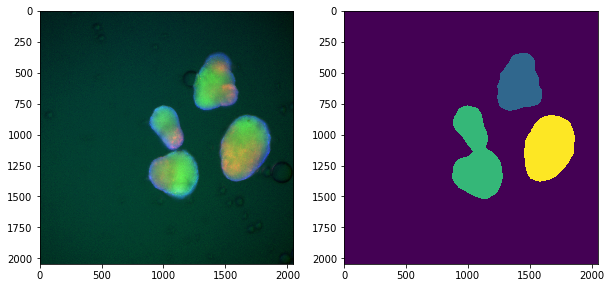

2 after filtering
2 after filtering
2 after filtering
MAL 476.3633960441524, ecc 0.6699504946791014
MAL 555.2292799551585, ecc 0.7116636982699971
Field of view 2
5 regions


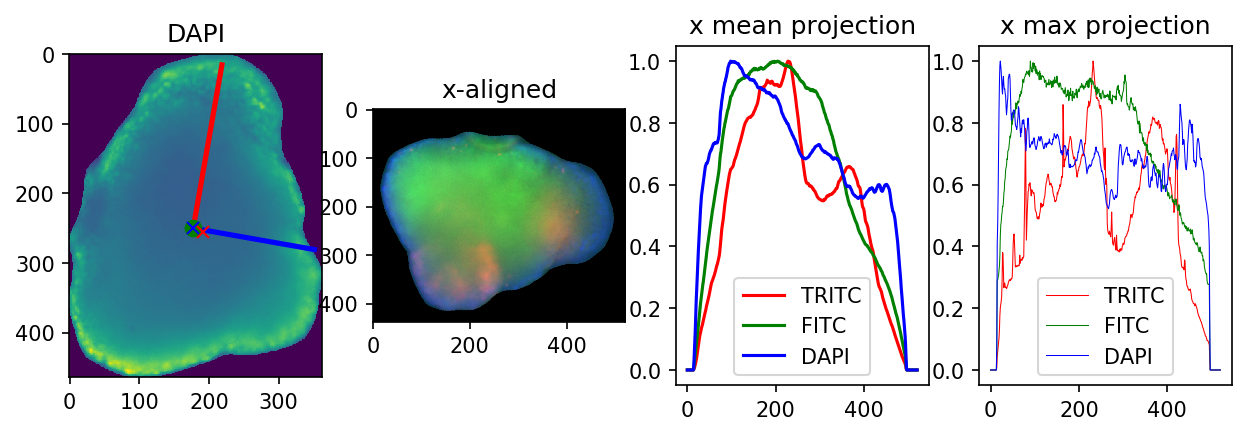

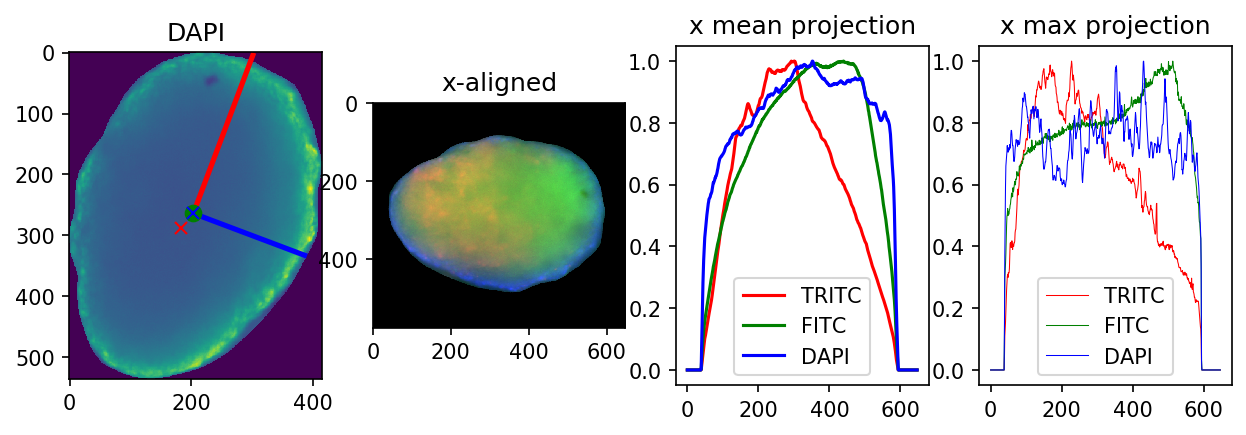

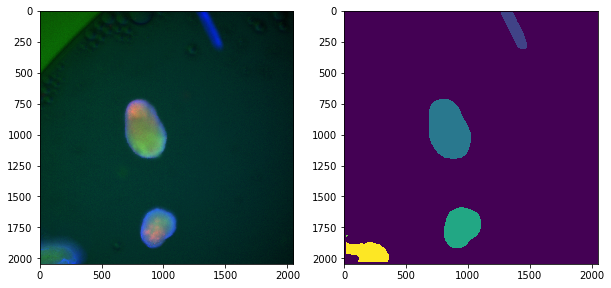

2 after filtering
2 after filtering
2 after filtering
MAL 508.9015864625201, ecc 0.7707228793807227
MAL 347.1494245878248, ecc 0.5892010452302452
Field of view 3
5 regions


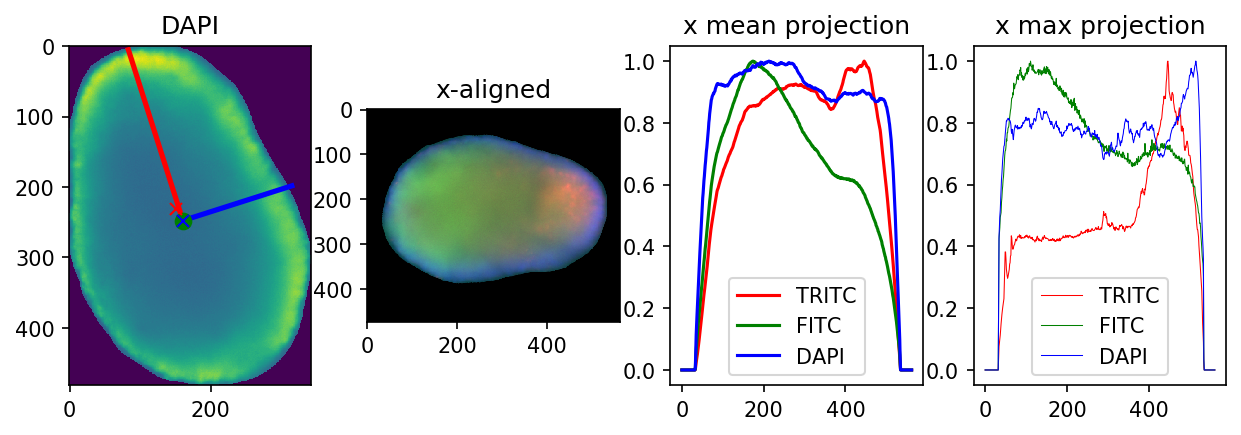

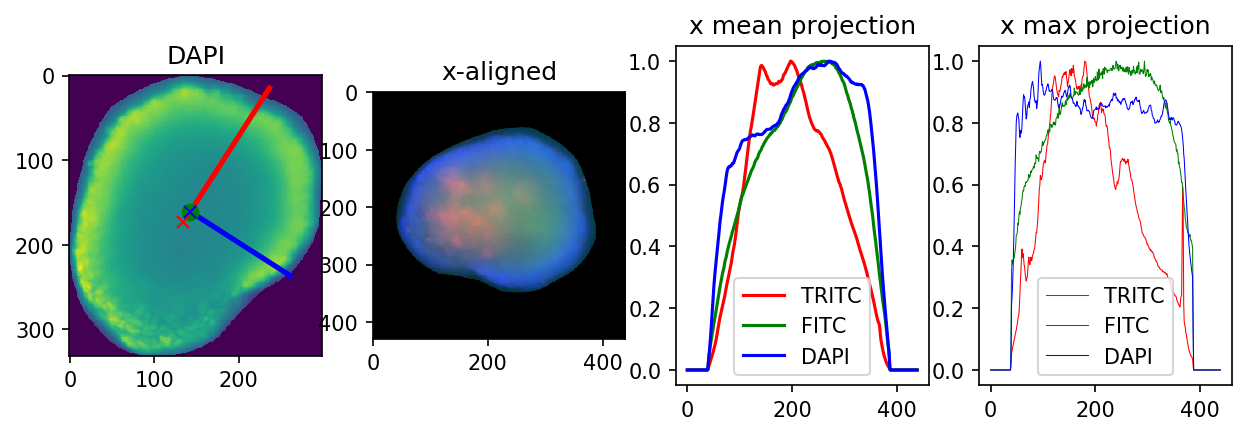

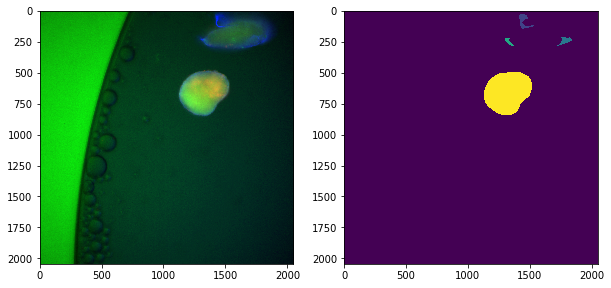

1 after filtering
1 after filtering
1 after filtering
MAL 404.5591700143066, ecc 0.5922370293260343
Field of view 4
1 regions


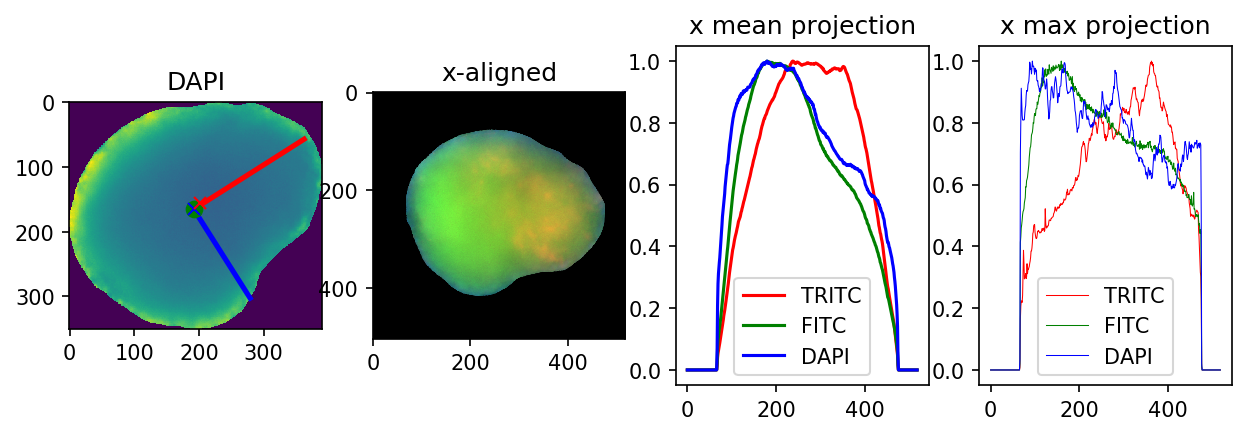

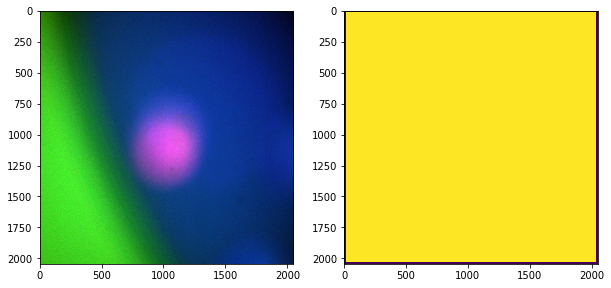

0 after filtering
0 after filtering
0 after filtering
Field of view 5
1 regions


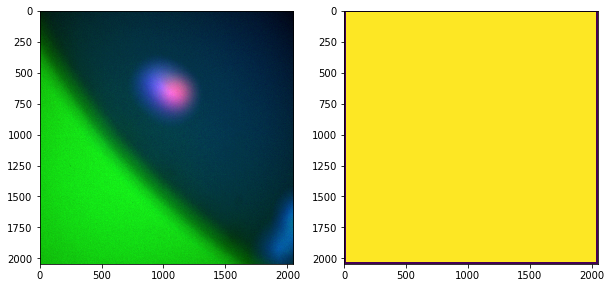

0 after filtering
0 after filtering
0 after filtering
Field of view 6
14 regions


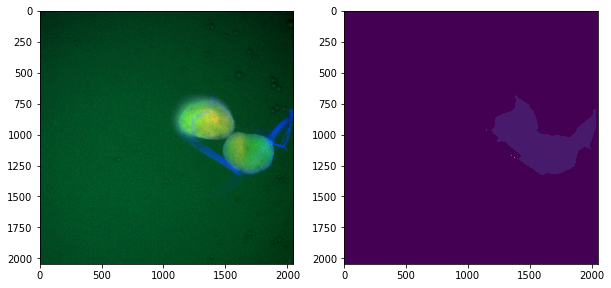

0 after filtering
0 after filtering
0 after filtering
Field of view 7
14 regions


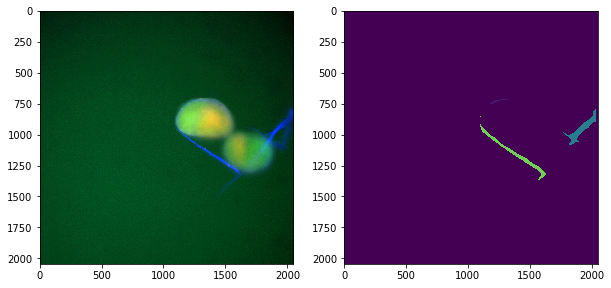

0 after filtering
0 after filtering
0 after filtering
Field of view 8
7 regions


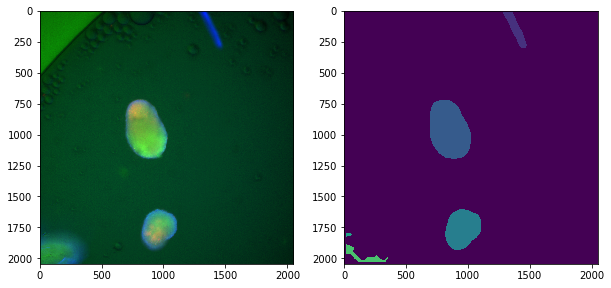

2 after filtering
2 after filtering
2 after filtering
MAL 501.45720955763915, ecc 0.7736063195664731
MAL 343.1232805515898, ecc 0.6143762335628465


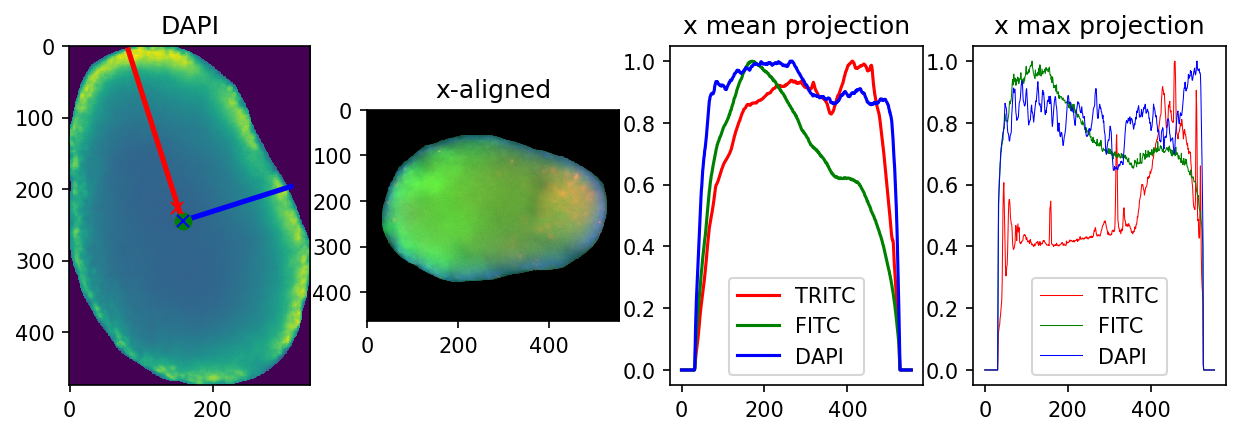

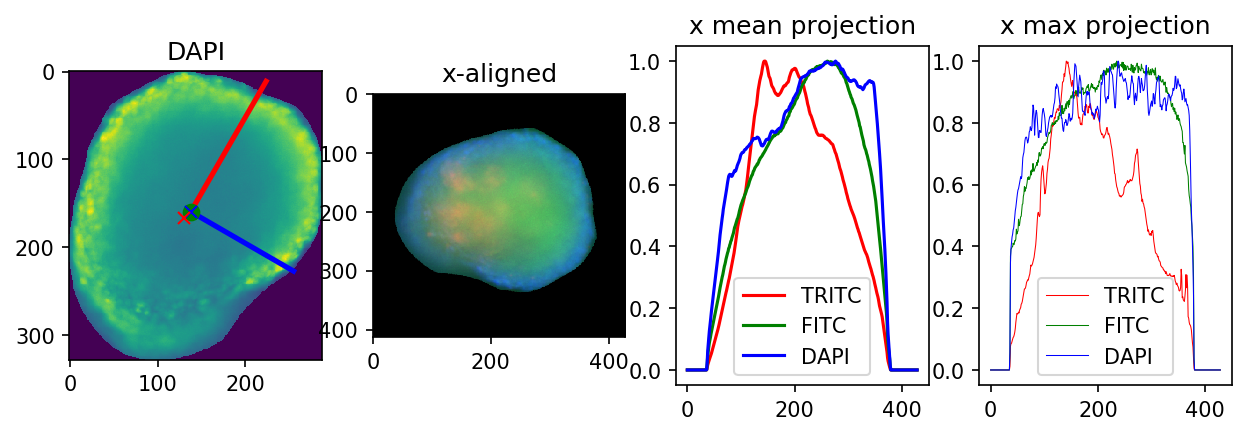

In [45]:
result = {'FOVs': {}}
for i, w in enumerate(well):
    print(f'Field of view {i+1}')
    result['FOVs'][i] = segment_multichannel(w)


In [142]:
r_profile = np.array(result['FOVs'][0]['organoids'][0]['intensity_profiles']['r']['max'])

In [137]:
a = map(sum, range(5))

In [139]:
a[]

In [187]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d as gf

def subsample_intensity_profile(values, n_samples=10, sigma=10, plot=False):
    '''
    Subsamples 1D curve.
    1. Cut off zero values
    2. Smooth with `sigma`
    3. Intepolate using vector with `n_samples` spots
    
    Return:
    -------
    Subsampled values
    '''
    r_profile = np.array(values, 'float')
    rf_profile = r_profile#[r_profile > 0]
    rfs_profile = gf(rf_profile, sigma)
    full_vector = np.arange(len(rfs_profile))
    approx = interp1d(full_vector, rfs_profile)
    vector = np.linspace(0, len(rfs_profile)-1, n_samples, endpoint=True)
    subsample = approx(vector)
    
    if plot:
        plt.plot(rf_profile)
        plt.plot(rfs_profile)
        plt.plot(vector, subsample, '.r')
    
    return subsample

array([0.01352204, 0.30229415, 0.46431859, 0.59528279, 0.75710012,
       0.34906461, 0.57650123, 0.54795542, 0.18056979, 0.00108256])

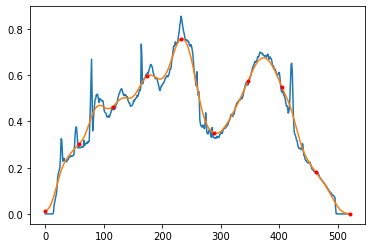

In [188]:
subsample_intensity_profile(r_profile, plot=1)

In [189]:
binned_profiles = [{c: subsample_intensity_profile(o['intensity_profiles'][c]['max']) for c in 'rg'} 
                   for f in result['FOVs'].values() 
                   for o in f['organoids'].values() 
                  ]

In [190]:
binned_profiles

[{'r': array([0.01352204, 0.30229415, 0.46431859, 0.59528279, 0.75710012,
         0.34906461, 0.57650123, 0.54795542, 0.18056979, 0.00108256]),
  'g': array([0.0435349 , 0.76180623, 0.85971751, 0.8122461 , 0.83245562,
         0.80962531, 0.67591924, 0.51457928, 0.37816313, 0.00359045])},
 {'r': array([2.49295806e-06, 4.44231094e-01, 8.19084706e-01, 7.69215718e-01,
         7.30123246e-01, 5.81810105e-01, 4.88390484e-01, 3.48236870e-01,
         2.03840198e-01, 0.00000000e+00]),
  'g': array([6.93340435e-06, 5.39294444e-01, 6.53557684e-01, 6.88058489e-01,
         7.00635682e-01, 7.18084169e-01, 7.96956517e-01, 8.56180001e-01,
         5.53009772e-01, 0.00000000e+00])},
 {'r': array([7.21034218e-05, 3.59688582e-01, 4.20938459e-01, 4.23377544e-01,
         4.46022291e-01, 4.63893969e-01, 5.25034186e-01, 8.56467920e-01,
         6.69956813e-01, 8.82244106e-04]),
  'g': array([2.68277148e-04, 6.29551483e-01, 7.35976737e-01, 6.85916914e-01,
         5.95250642e-01, 5.38353156e-01, 5.16654

In [191]:
def orient(curve, color):
    curve = curve / curve.sum()
    if color == 'r':
        if curve.argmax() < 4:
            return curve[::-1], 'm'
        return curve, 'm'
    elif color == 'g':
        if curve.argmax() > 4:
            return curve[::-1], 'c'
        return curve, 'c'
    else:
        raise ValueError(f'expected color "r" or "g", got {color}')

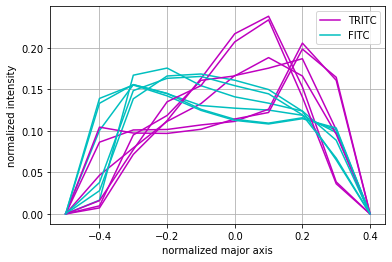

In [192]:
_ = [plt.plot((np.arange(len(p)) - len(p) // 2) / len(p) , *orient(p, c)) for p in binned_profiles[1:] for c, p in p.items() ]
plt.xlabel('normalized major axis')
plt.ylabel('normalized intensity')
plt.legend(['TRITC', 'FITC'])
plt.grid()

In [135]:
def test_subsample_intensity_profile(l=500):
    vect = np.arange(l)
    noise = np.random.normal(scale=0.3, size=l)
    sin = np.sin(vect / l * 10) + 1 + noise
    res10 = subsample_intensity_profile(sin, sigma=10, n_samples=10, plot=True)
    assert len(res10) == 10
    print(res10.std(), sin.std())
    np.testing.assert_almost_equal(res10.std(), sin.std(), 1)

0.5824696807617682 0.7646194156424806


AssertionError: 
Arrays are not almost equal to 1 decimals
 ACTUAL: 0.5824696807617682
 DESIRED: 0.7646194156424806

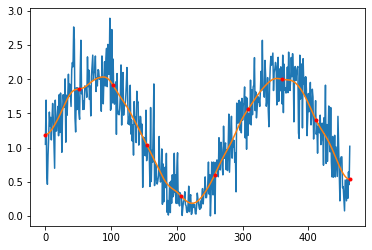

In [136]:
test_subsample_intensity_profile()

In [78]:
res10 = subsample_intensity_profile(r_profile)

In [80]:
np.std(r_profile), res10.std()

(0.2128, 0.20581207043327898)

In [ ]:
result

In [46]:
import json

with open(fluo_path.replace('.nd2', '_profiles.json'), 'w') as fp:
    json.dump(result, fp)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/SUMOICC/8001_profiles.json'

3 regions


<ipython-input-625-b14486878543>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


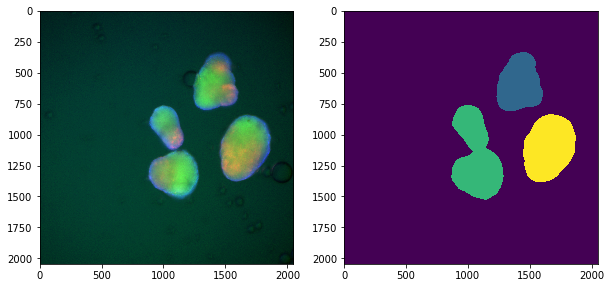

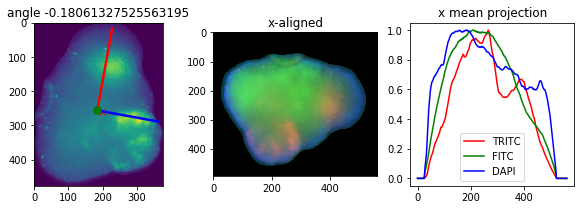

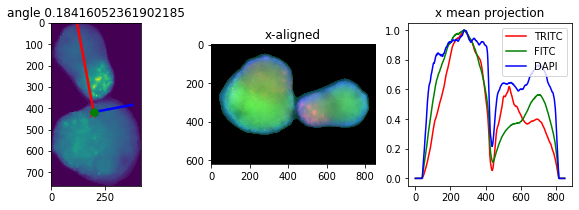

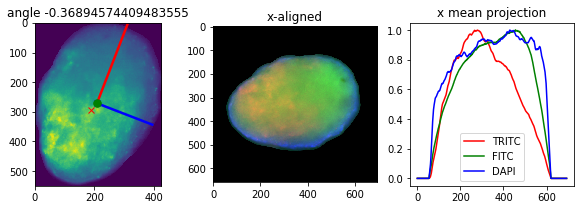

In [626]:
segment_multichannel(w)

float64
3 regions


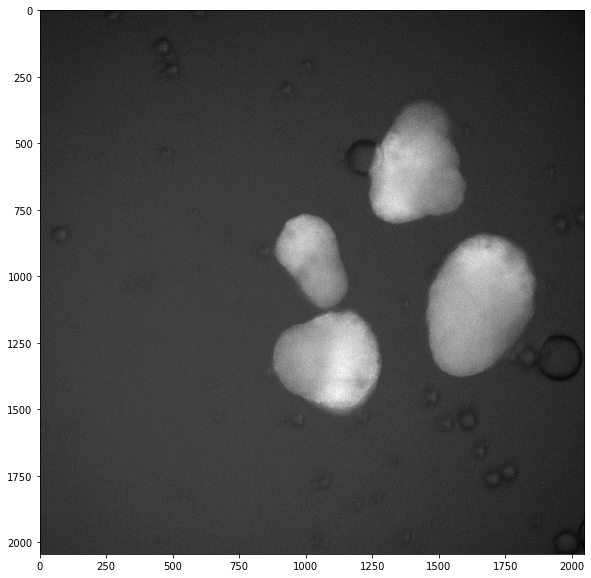

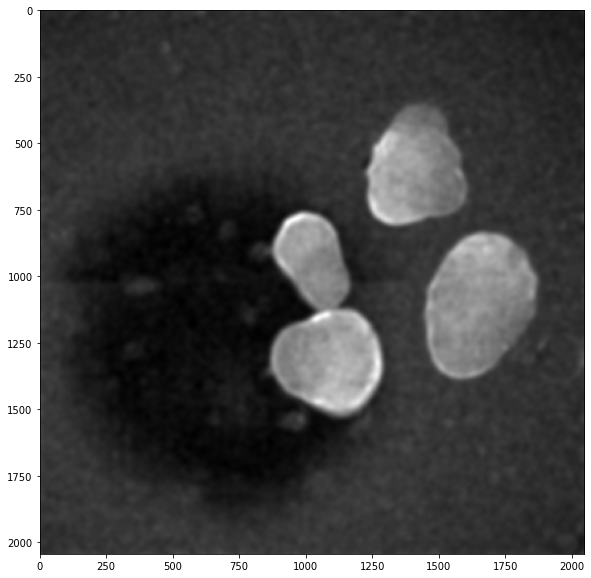

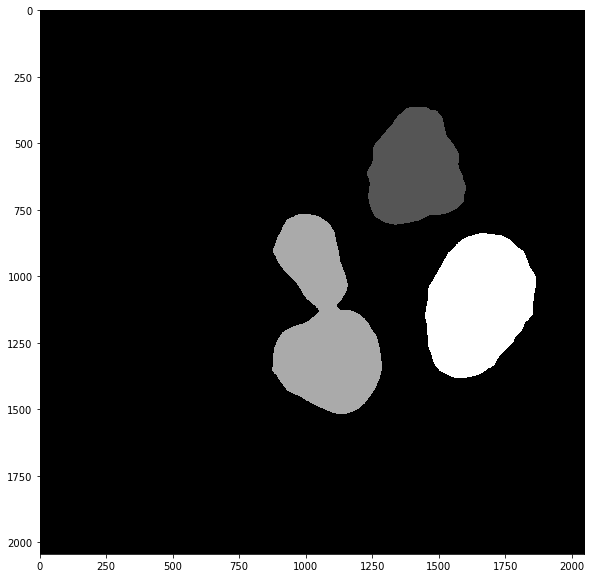

In [420]:
img = w[1]

print(img.dtype)
multiwell.show(img)
all_reg = segment_bf(img, thr=0.5, erode=10, plot=True)

In [ ]:
porps = multiwell.regionprops_table(all_reg, )

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 <Figure size 720x216 with 4 Axes>)

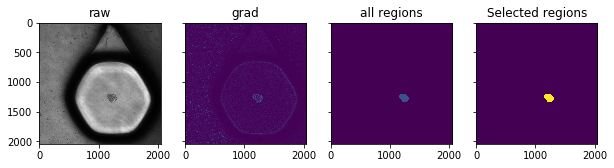

In [103]:
segment.findSpheroid(well, erode=10, threshold=0.3, plot=1)

In [318]:
well = read_nd2(path, well_index=None)

Frame([[11151, 12075, 11889, ...,  7696,  7854,  7350],
       [11727, 12543, 12170, ...,  7551,  7812,  7106],
       [12030, 12831, 12706, ...,  7882,  7666,  7536],
       ...,
       [14321, 14602, 15073, ..., 10629, 11187, 11053],
       [13924, 15074, 15004, ...,  9556, 10363, 10616],
       [14476, 15002, 14713, ...,  9191,  9769, 10144]], dtype=uint16)
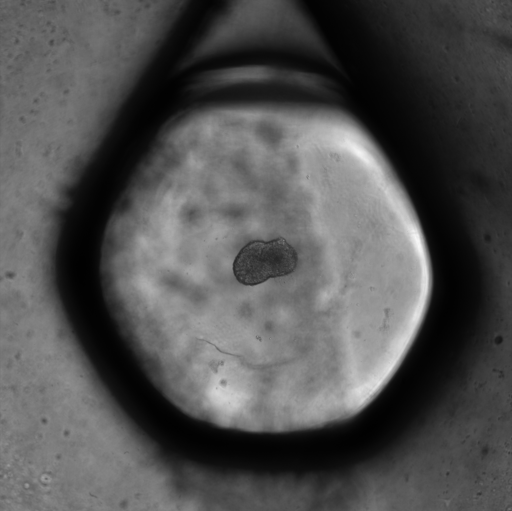

In [329]:
next(well)

1 regions
selected region []
nothing found


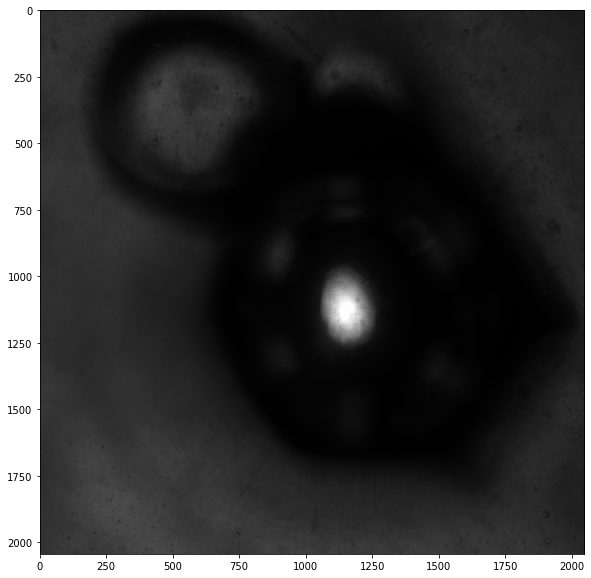

7 regions
selected region [4]
selected region [19]


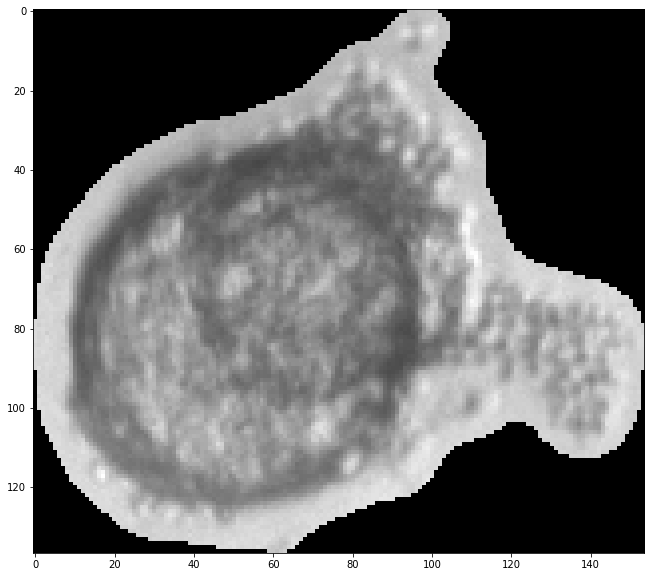

2 regions
selected region []
nothing found


<ipython-input-285-0fb8ee8b5f56>:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  well_crop = props_table['intensity_image'][props_table['label'] == reg_label][0]


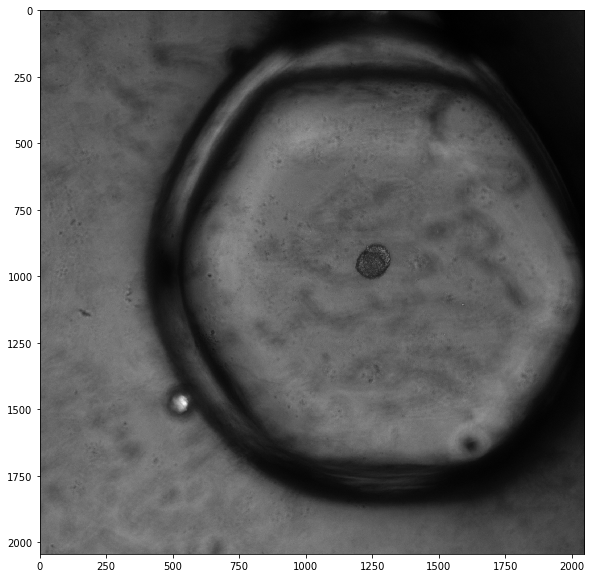

1 regions
selected region []
nothing found


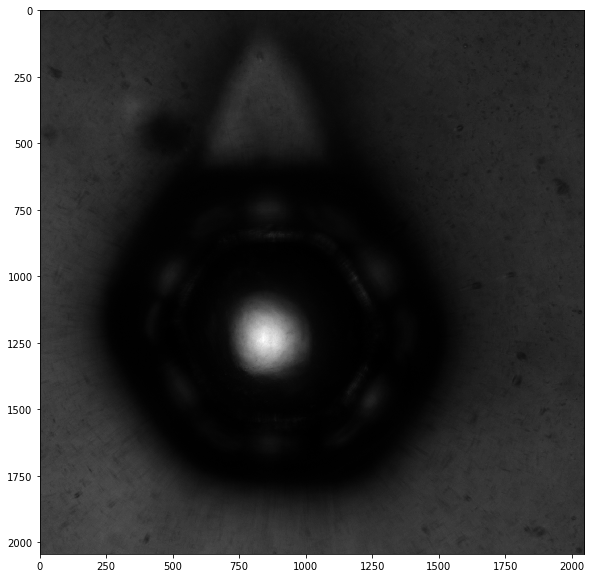

5 regions
selected region []
nothing found


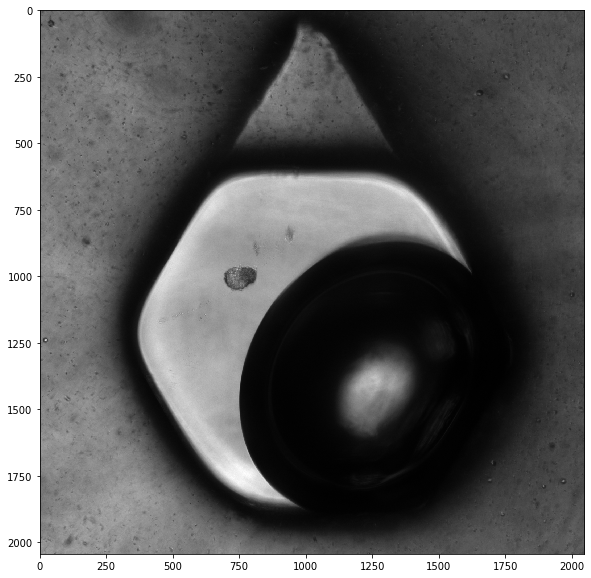

In [316]:
for w in well:
    try:
        multiwell.show(get_organoid(w).crop)
        multiwell.plt.show()
    except IndexError:
        print('nothing found')
        multiwell.show(w)
        multiwell.plt.show()
        

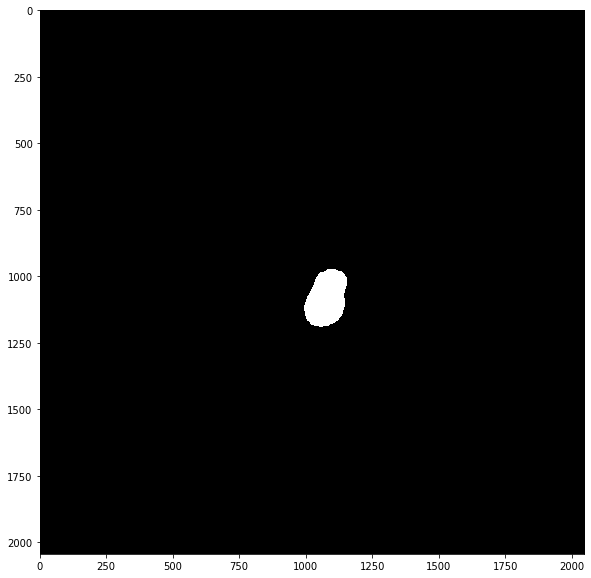

In [301]:
seg  = segment.findSpheroid(well, threshold=.2)
multiwell.show(seg)

5 regions
selected region [5]
selected region [4]


Frame([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
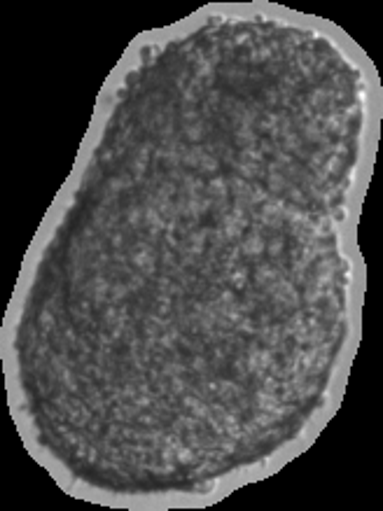

In [302]:
get_organoid(well, ).crop

In [126]:
def process(img, index=0, save=True, dirr=dirr):
    index = img["index"]
    print(f'Processing {index} well')
    seg = segment.findSpheroid(
        img['well'], 
        threshold=0.3,
        erode=5,
        sigma=5, 
        lim_major_axis_length=(50, 300), 
        plot=0)
    if save:
        stack = np.array([img['well'], seg], dtype='uint16')
        well = tools.Well(stack, order='cyx', calibration_um=img['calibration_um'])
        well.save_tif(os.path.join(dirr, f'Pos_{index:03d}.tif'))
    res = segment.get_props(seg, well_index=index)
    
    print(res)
    if len(res) > 1:
        res = res[np.argmax([a['area'] for a in res])]
    
        print(res)
        return res
    elif len(res) == 1:
        return res[0]
    else:
        return {'well_index': index}

In [63]:
reader = tools.read_nd2(path)

In [64]:
res = list(map(process, tools.tqdm(reader)))

/Users/andrey/miniconda3/envs/nd2/lib/python3.8/site-packages/pims/base_frames.py:522: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


Processing 0 well
[]
Processing 1 well
[{'area': 1061, 'eccentricity': 0.8875643105055699, 'major_axis_length': 87.10969915371032, 'well_index': 1}, {'area': 19333, 'eccentricity': 0.7834937206624811, 'major_axis_length': 200.33356492118685, 'well_index': 1}]
{'area': 19333, 'eccentricity': 0.7834937206624811, 'major_axis_length': 200.33356492118685, 'well_index': 1}
Processing 2 well
[{'area': 5610, 'eccentricity': 0.37137793189761575, 'major_axis_length': 88.07041158138591, 'well_index': 2}]
Processing 3 well
[{'area': 18924, 'eccentricity': 0.6605673033934284, 'major_axis_length': 180.23080512791645, 'well_index': 3}]
Processing 4 well
[{'area': 14525, 'eccentricity': 0.18293477713029851, 'major_axis_length': 137.20997934556112, 'well_index': 4}, {'area': 524, 'eccentricity': 0.9478348188461485, 'major_axis_length': 54.80310831626083, 'well_index': 4}, {'area': 2073, 'eccentricity': 0.405656356162915, 'major_axis_length': 55.08168744324297, 'well_index': 4}]
{'area': 14525, 'eccentr

In [65]:
res

[{'well_index': 0},
 {'area': 19333,
  'eccentricity': 0.7834937206624811,
  'major_axis_length': 200.33356492118685,
  'well_index': 1},
 {'area': 5610,
  'eccentricity': 0.37137793189761575,
  'major_axis_length': 88.07041158138591,
  'well_index': 2},
 {'area': 18924,
  'eccentricity': 0.6605673033934284,
  'major_axis_length': 180.23080512791645,
  'well_index': 3},
 {'area': 14525,
  'eccentricity': 0.18293477713029851,
  'major_axis_length': 137.20997934556112,
  'well_index': 4},
 {'area': 15685,
  'eccentricity': 0.5598042850374028,
  'major_axis_length': 155.47113451127862,
  'well_index': 5},
 {'area': 15776,
  'eccentricity': 0.7341986441264999,
  'major_axis_length': 172.35517722374559,
  'well_index': 6},
 {'area': 26206,
  'eccentricity': 0.43665126279180566,
  'major_axis_length': 193.1256561576455,
  'well_index': 7},
 {'area': 21405,
  'eccentricity': 0.8668983794241605,
  'major_axis_length': 237.7283944276819,
  'well_index': 8},
 {'well_index': 9},
 {'well_index': 1

In [66]:
import pandas as pd
from functools import reduce
from operator import add

In [67]:
df = pd.DataFrame(res)

In [68]:
df

well_index     area  eccentricity  major_axis_length
0            0      NaN           NaN                NaN
1            1  19333.0      0.783494         200.333565
2            2   5610.0      0.371378          88.070412
3            3  18924.0      0.660567         180.230805
4            4  14525.0      0.182935         137.209979
5            5  15685.0      0.559804         155.471135
6            6  15776.0      0.734199         172.355177
7            7  26206.0      0.436651         193.125656
8            8  21405.0      0.866898         237.728394
9            9      NaN           NaN                NaN
10          10      NaN           NaN                NaN
11          11  20882.0      0.779407         208.460260
12          12  12046.0      0.430991         130.665278
13          13  16203.0      0.876343         211.341633
14          14   3364.0      0.363593          68.924094
15          15  15214.0      0.298063         142.570281
16          16  17214.0      0.161600         149.220520
17          17  18561.0      0.339179         158.656743
18          18  27642.0      0.748321         235.262495
19          19  25180.0      0.722374         216.426336
20          20    992.0      0.946042          75.331583
21          21  17145.0      0.363863         153.337947
22          22  24167.0      0.792385         225.981098
23          23  22788.0      0.751732         210.762490
24          24  12873.0      0.729776         156.308193
25          25  22762.0      0.645316         195.457640
26          26  19846.0      0.494209         171.698196
27          27   1107.0      0.782276          55.210766
28          28      NaN           NaN                NaN
29          29   5296.0      0.562684          90.622547
30          30   8679.0      0.742301         157.624718
31          31   8293.0      0.322734         106.123681
32          32      NaN           NaN                NaN
33          33      NaN           NaN                NaN
34          34   1407.0      0.927234          78.450574
35          35      NaN           NaN                NaN
36          36  17471.0      0.649470         171.477674
37          37   9026.0      0.883510         227.817118
38          38  16296.0      0.561160         158.977726
39          39  10781.0      0.380734         122.090263
40          40   4183.0      0.755723         122.256059
41          41   8754.0      0.783762         137.082184
42          42  46407.0      0.667744         282.762532
43          43  10400.0      0.648285         137.099423
44          44  12796.0      0.440834         135.559312
45          45  14071.0      0.811271         212.375166
46          46   9454.0      0.723816         132.889233

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1306f06d0>]],
      dtype=object)

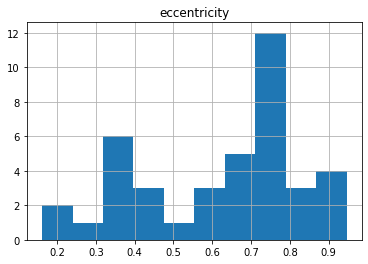

In [69]:
df.hist('eccentricity', bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130890d00>]],
      dtype=object)

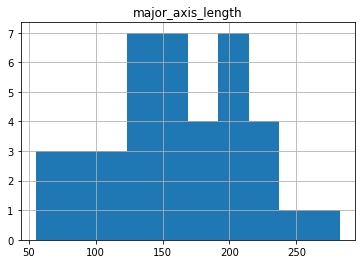

In [71]:
df.hist('major_axis_length', bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x143e31370>]],
      dtype=object)

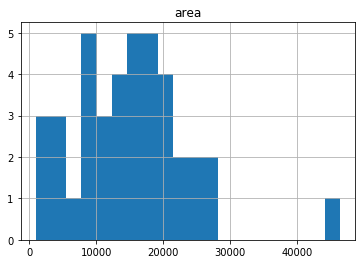

In [74]:
df.hist('area', bins=20)

In [72]:
df.to_csv(path.replace('.nd2', '_shapes.csv'))